In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Combined model (LR) 

### RIH data total = 220 cases (Hypo = 106, non = 114)

In [2]:
cli = pd.read_excel('outcome.xlsx', header = 0, index_col = 0)
cli.head()

,Hypo
ID,
1,1
2,1
3,1
4,0
5,1


In [3]:
# Defined label
label = cli.iloc[:,0]
label.head(3)

ID
1    1
2    1
3    1
Name: Hypo , dtype: int64

### Combined data

In [4]:
data_processed = pd.read_excel('input_LR.xlsx', header = 0, index_col = 0)
data_processed.head()

,Sex,Age,FT4_Before_RT,TSH_Before_RT,TR_Volume,Stage_1,Stage_2,Stage_3,Stage_4,Stage_5,...,v1276,v1277,v1278,v1279,v1280,v1283,v1284,v1285,v1286,v1287
ID,,,,,,,,,,,,,,,,,,,,,
1,1,26,1.38,2.73,13.1,0,1,0,0,0,...,1762.779584,309.496542,569620.247008,0.168848,0.000582,0.000020,1.936930,0.000140,447.758339,0.001169
2,2,48,1.26,1.68,9.9,0,0,1,0,0,...,1294.616010,293.255701,382142.974154,0.231494,0.000822,0.000022,1.648819,0.000110,1225.174465,0.000972
3,1,55,1.24,1.81,10.6,0,0,0,1,0,...,2061.715653,279.915485,604719.804245,0.129961,0.000504,0.000025,1.222319,0.000225,479.728854,0.001821
4,1,56,1.34,0.33,14.0,0,0,0,1,0,...,1252.355627,332.693153,432401.996587,0.256888,0.000816,0.000026,3.322900,0.000159,224.301554,0.002015
5,2,67,0.98,1.58,6.1,0,0,1,0,0,...,1975.856335,231.884005,478335.397246,0.112917,0.000547,0.000053,0.661655,0.000373,643.547168,0.002047


## Split data to train:test = 80%:20%

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data_processed, label, test_size = 0.2, stratify = label, \
                                                    shuffle = True, random_state = 999) 

In [6]:
print('Train group = ',X_train.shape)
print('Test group = ', X_test.shape)

Train group =  (176, 1059)
Test group =  (44, 1059)


## Standardize data using mean and SD estimates from the training set

In [7]:
X_scaler = StandardScaler(with_mean = True, with_std = True).fit(X_train)

X_train_std = pd.DataFrame(X_scaler.transform(X_train), index = X_train.index, columns = X_train.columns)
X_test_std = pd.DataFrame(X_scaler.transform(X_test), index = X_test.index, columns = X_test.columns)

## Preliminary model evaluation

## Logistic regression

In [8]:
log_reg_models = {} 

for penalty in ['l1', 'l2']:
    for C in [0.001, 0.01, 0.1, 1, 10]:
        name = 'LR-P' + penalty + 'C' + str(C)
        log_reg_models[name] = LogisticRegression(penalty = penalty, C = C, random_state = 111, \
                                                  max_iter = 100000, solver = 'liblinear')

In [9]:
def get_cv_results(X, y, models):
    skfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 111)
    cv_results = {m:{'coef':[], 'train accuracy':[], 'train AUC':[], 'confusion matrix':[], \
                 'test accuracy':[], 'test AUC':[]} for m in models}

    for train_index, val_index in skfold.split(X, y):
        X_train_cv = X.iloc[train_index, :]
        y_train_cv = y.iloc[train_index]

        X_val = X.iloc[val_index, :]
        y_val = y.iloc[val_index]

        for m in cv_results: 
            model = models[m] 
            model.fit(X_train_cv, y_train_cv)

            y_fitted = model.predict_proba(X_train_cv)[:, 1]
            y_fitted_class = model.predict(X_train_cv)

            y_predict = model.predict_proba(X_val)[:, 1]
            y_predict_class = model.predict(X_val)

            ## Add [m] to point results to the dictionary entry for the current model
            cv_results[m]['coef'].append(model.coef_[0])
            cv_results[m]['train accuracy'].append(accuracy_score(y_train_cv, y_fitted_class))
            cv_results[m]['train AUC'].append(roc_auc_score(y_train_cv, y_fitted))

            cv_results[m]['confusion matrix'].append(confusion_matrix(y_val, y_predict_class))
            cv_results[m]['test accuracy'].append(accuracy_score(y_val, y_predict_class))
            cv_results[m]['test AUC'].append(roc_auc_score(y_val, y_predict))
            
    return cv_results

In [10]:
cv_results = get_cv_results(X_train_std, y_train, log_reg_models)

### Calculate average validation performances sort models by AUC

In [11]:
models = [m for m in cv_results]
val_acc_all = [np.mean(cv_results[m]['test accuracy']) for m in cv_results]
val_auc_all = [np.mean(cv_results[m]['test AUC']) for m in cv_results]
val_acc_sd_all = [np.std(cv_results[m]['test accuracy']) for m in cv_results]
val_auc_sd_all = [np.std(cv_results[m]['test AUC']) for m in cv_results]

model_order = np.argsort(val_auc_all)[::-1]

for i in model_order:
    print(models[i], 'validation acc =', val_acc_all[i], 'acc sd =', val_acc_sd_all[i] , 
                     'validation AUC =', val_auc_all[i], 'AUC sd=', val_auc_sd_all[i])

LR-Pl2C0.001 validation acc = 0.5685714285714285 acc sd = 0.08494896427039147 validation AUC = 0.5900584795321638 AUC sd= 0.09461291454515877
LR-Pl1C0.1 validation acc = 0.5395238095238095 acc sd = 0.06753851676758629 validation AUC = 0.5734778121775025 AUC sd= 0.0859480686684646
LR-Pl2C0.01 validation acc = 0.5404761904761904 acc sd = 0.10018124165300768 validation AUC = 0.5642242862057104 AUC sd= 0.09849101985786976
LR-Pl1C1 validation acc = 0.5861904761904763 acc sd = 0.10537052645690345 validation AUC = 0.5638114895080839 AUC sd= 0.11731753681290806
LR-Pl2C0.1 validation acc = 0.5119047619047619 acc sd = 0.08726117390715832 validation AUC = 0.5394908840729273 AUC sd= 0.08558998562776449
LR-Pl2C1 validation acc = 0.5176190476190475 acc sd = 0.06713441351838897 validation AUC = 0.5279325765393877 AUC sd= 0.08323216548800523
LR-Pl2C10 validation acc = 0.5006349206349207 acc sd = 0.06275444552665992 validation AUC = 0.5272101823185416 AUC sd= 0.07742043057415311
LR-Pl1C10 validation ac

- Select the LR-Pl2C0.001 model to explore further

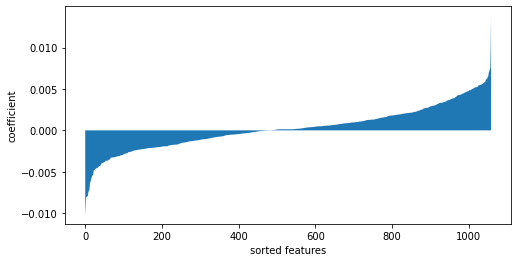

In [12]:
# distribution of feature coefficients 
feature_coeffs = pd.DataFrame(np.mean(cv_results['LR-Pl2C0.001']['coef'], axis = 0), \
                              index = X_train_std.columns.values, columns = ['coefficients'])
feature_coeffs.sort_values('coefficients', inplace = True)

plt.figure(figsize = (8, 4))
plt.fill_between(range(feature_coeffs.shape[0]), np.zeros((feature_coeffs.shape[0], )), feature_coeffs.iloc[:, 0])
plt.xlabel('sorted features'); plt.ylabel('coefficient')
plt.show()

## Feature selection with Recursive Feature Elimination

In [13]:
base_estimator = LogisticRegression(penalty = 'l2', C = 0.001, random_state = 111, max_iter = 100000, solver = 'liblinear')

top_features = list(feature_coeffs.index.values[:15])
top_features.extend(feature_coeffs.index.values[-15:])
X_top_features = X_train_std.loc[:, top_features]

rfecv = RFECV(base_estimator, step = 1, cv = 5, n_jobs = 2, importance_getter = 'auto').fit(X_top_features, y_train)

In [14]:
print('number of selected features:', len(X_top_features.columns.values[rfecv.support_]))

number of selected features: 30


In [15]:
# Perform another round of cross-validation to evaluate the effect of feature selection
X_selected_features = X_top_features.loc[:, rfecv.support_]
rfe_cv_results = get_cv_results(X_selected_features, y_train, log_reg_models)

In [16]:
X_selected_features

,Age,v1084,v616,v1208,v25,v139,v536,v1082,v608,v808,...,v594,v193,v1263,v437,TSH_Before_RT,v284,TR_V40,v169,v195,N2
ID,,,,,,,,,,,,,,,,,,,,,
168,0.734820,-1.209629,0.034099,0.997414,0.994476,-0.547876,0.267012,-1.265993,0.239110,-1.102786,...,1.024671,-0.478427,-1.082396,-0.519550,-0.206119,-0.711432,0.481492,-0.154294,0.243087,0.765236
85,-0.032960,-1.245782,-0.645889,1.044765,1.027954,0.617328,-0.821122,-1.709217,0.246296,0.675232,...,0.894048,-0.975978,-0.173843,0.655652,-0.236501,-0.932041,0.130049,-1.308231,-0.681742,0.765236
107,-0.032960,-0.056734,-0.004478,1.015647,0.988811,-0.204332,-1.443668,0.536243,0.224308,-1.072113,...,0.835855,0.201607,-0.904230,-0.016759,0.085258,-0.053290,0.379254,-0.260037,0.117124,0.765236
217,-0.886050,-0.807151,0.738661,-2.236422,-2.251442,1.304118,0.266564,-0.122716,0.314417,-0.170431,...,-0.681343,1.133239,1.113263,-0.816707,-0.190129,0.935873,-1.812477,0.203238,-1.347106,0.765236
23,-0.203578,0.163814,0.670674,1.034735,1.025246,0.771773,0.242194,-0.377526,0.792122,1.691587,...,0.128593,2.135484,1.112884,3.280847,0.085258,3.646164,0.015031,-0.593098,-0.418663,-1.306787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,-0.715432,0.083216,0.189546,-0.508765,-0.486408,0.258309,0.292570,0.505018,0.036786,0.787162,...,-0.803975,-0.810497,-0.014716,-0.378153,0.040841,-0.924822,0.385644,-0.602550,-0.270103,0.765236
18,0.734820,0.438225,1.368032,1.168380,1.169961,0.786234,1.486182,-0.514829,0.460861,1.114373,...,-0.703554,2.081812,1.161761,1.924621,0.200743,1.003919,0.462323,-1.165056,0.281604,0.765236
118,0.905438,-0.428287,0.297247,1.133742,1.151166,0.931129,0.723139,-0.532780,0.377769,-1.152624,...,0.100914,0.071368,0.436073,-0.008974,-0.233836,0.178006,0.507052,-1.328723,-0.548234,-1.306787


In [17]:
# training set
models = [m for m in rfe_cv_results]
rfe_train_acc_all = [np.mean(rfe_cv_results[m]['train accuracy']) for m in rfe_cv_results]
rfe_train_auc_all = [np.mean(rfe_cv_results[m]['train AUC']) for m in rfe_cv_results]
rfe_train_acc_sd_all = [np.std(rfe_cv_results[m]['train accuracy']) for m in rfe_cv_results]
rfe_train_auc_sd_all = [np.std(rfe_cv_results[m]['train AUC']) for m in rfe_cv_results]

rfe_model_order = np.argsort(rfe_train_auc_all)[::-1]

for i in rfe_model_order:
    print(models[i], 'train acc =', rfe_train_acc_all[i], 'sd acc =', rfe_train_acc_sd_all[i],
          'train AUC =', rfe_train_auc_all[i], 'sd AUC =', rfe_train_auc_sd_all[i])

LR-Pl1C10 train acc = 0.8253191489361702 sd acc = 0.016215564125042523 train AUC = 0.8942939161966157 sd AUC = 0.006819335548604835
LR-Pl2C10 train acc = 0.8224721377912866 sd acc = 0.013106911797068417 train AUC = 0.8941724863461367 sd AUC = 0.0067240295981211996
LR-Pl2C1 train acc = 0.8210435663627154 sd acc = 0.01349335641750651 train AUC = 0.8888066299579194 sd AUC = 0.0069490335957358915
LR-Pl1C1 train acc = 0.815390070921986 sd acc = 0.026254165827131245 train AUC = 0.8850148849494135 sd AUC = 0.007655012859267041
LR-Pl2C0.1 train acc = 0.806838905775076 sd acc = 0.01489017046185679 train AUC = 0.8757324961948252 sd AUC = 0.00871327621267028
LR-Pl2C0.01 train acc = 0.7770010131712259 sd acc = 0.012134391020530806 train AUC = 0.8432676381054705 sd AUC = 0.01242406829015968
LR-Pl2C0.001 train acc = 0.7216008105369808 sd acc = 0.018550542625471293 train AUC = 0.8017649297161787 sd AUC = 0.012230373025764706
LR-Pl1C0.1 train acc = 0.7102532928064843 sd acc = 0.027162090748678504 trai

In [18]:
# validation set
models = [m for m in rfe_cv_results]
rfe_val_acc_all = [np.mean(rfe_cv_results[m]['test accuracy']) for m in rfe_cv_results]
rfe_val_auc_all = [np.mean(rfe_cv_results[m]['test AUC']) for m in rfe_cv_results]
rfe_val_acc_sd_all = [np.std(rfe_cv_results[m]['test accuracy']) for m in rfe_cv_results]
rfe_val_auc_sd_all = [np.std(rfe_cv_results[m]['test AUC']) for m in rfe_cv_results]

rfe_model_order = np.argsort(rfe_val_auc_all)[::-1]

for i in rfe_model_order:
    print(models[i], 'validation acc =', rfe_val_acc_all[i], 'sd acc =', rfe_val_acc_sd_all[i],
          'validation AUC =', rfe_val_auc_all[i], 'sd AUC =', rfe_val_auc_sd_all[i])

LR-Pl2C0.1 validation acc = 0.7222222222222221 sd acc = 0.06719368409052928 validation AUC = 0.800859993120055 sd AUC = 0.06061143655503485
LR-Pl2C0.01 validation acc = 0.710952380952381 sd acc = 0.08372831563457053 validation AUC = 0.7895080839353285 sd AUC = 0.0785903403503202
LR-Pl2C1 validation acc = 0.704920634920635 sd acc = 0.039230440512910233 validation AUC = 0.7727554179566564 sd AUC = 0.05059782074205101
LR-Pl2C0.001 validation acc = 0.6941269841269841 sd acc = 0.09657213821055653 validation AUC = 0.7670450636394908 sd AUC = 0.08609548114492205
LR-Pl1C1 validation acc = 0.687936507936508 sd acc = 0.043869294400316686 validation AUC = 0.7630202958376333 sd AUC = 0.05228660854018083
LR-Pl2C10 validation acc = 0.6763492063492064 sd acc = 0.02602593818293282 validation AUC = 0.7270037839697283 sd AUC = 0.05782463792369124
LR-Pl1C10 validation acc = 0.6592063492063491 sd acc = 0.039137849034014675 validation AUC = 0.7263157894736841 sd AUC = 0.057741698003848194
LR-Pl1C0.1 valida

### ROC curves on the test set

In [19]:
model = LogisticRegression(penalty = 'l2', C = 0.1, random_state = 111, max_iter = 100000, solver = 'liblinear')
model.fit(X_selected_features, y_train)
y_predict_feature_selected = model.predict_proba(X_test_std.loc[:, X_selected_features.columns.values])[:, 1]
y_predict_class_feature_selected = model.predict(X_test_std.loc[:, X_selected_features.columns.values])

print('with feature selection:')
print('accuracy:', accuracy_score(y_test, y_predict_class_feature_selected))
print('ROC AUC:', roc_auc_score(y_test, y_predict_feature_selected))

with feature selection:
accuracy: 0.7272727272727273
ROC AUC: 0.7204968944099378


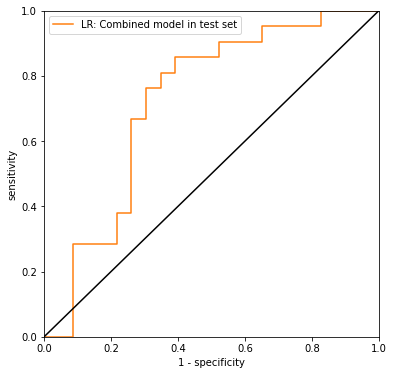

In [20]:
plt.figure(figsize = (6, 6))

fpr, tpr, thresholds = roc_curve(y_test, y_predict_feature_selected)
plt.plot(fpr, tpr, c = 'tab:orange', label = 'LR: Combined model in test set')

plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('1 - specificity'); plt.ylabel('sensitivity')
plt.axis([0, 1, 0, 1])
plt.legend()
plt.show()

In [21]:
def show_details(model, X_test, y_test):
    y_pred_class = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_class)
    
    print('  Model accuracy:', acc)
    
    conf_mat = confusion_matrix(y_test, y_pred_class)
    conf_mat = pd.DataFrame(conf_mat, index = ['Known 0', 'Known 1'], columns = ['Predicted 0', 'Predicted 1'])
    
    print('  Confusion matrix:')
    print(conf_mat)

In [22]:
show_details(model, X_test_std.loc[:, X_selected_features.columns.values], y_test)

  Model accuracy: 0.7272727272727273
  Confusion matrix:
         Predicted 0  Predicted 1
Known 0           15            8
Known 1            4           17


In [23]:
print(classification_report(y_test, y_predict_class_feature_selected))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71        23
           1       0.68      0.81      0.74        21

    accuracy                           0.73        44
   macro avg       0.73      0.73      0.73        44
weighted avg       0.74      0.73      0.73        44



In [24]:
# lebel selected features
data = ['Age', 'WL-HHL_glszm_SmallAreaLowGrayLevelEmphasis', 'WL-LLH_glrlm_ShortRunLowGrayLevelEmphasis',
        'wavelet-LLL_firstorder_Minimum', 'original_firstorder_Minimum', 'log-sigma-1-0-mm-3D_glcm_Idmn',
        'log-sigma-5-0-mm-3D_glszm_SmallAreaEmphasis', 'WL-HHL_glszm_SmallAreaEmphasis', 'WL-LLH_glrlm_LowGrayLevelRunEmphasis',
        'WL-LHH_glszm_SizeZoneNonUniformityNormalized', 'WL-LLH_ngtdm_Contrast', 'WL-LHH_glszm_SmallAreaEmphasis',
        'WL-HHL_glszm_SizeZoneNonUniformityNormalized', 'WL-LHH_glszm_SmallAreaHighGrayLevelEmphasis',
        'log-sigma-5-0-mm-3D_glszm_SizeZoneNonUniformityNormalized', 'WL-LLH_glszm_SizeZoneNonUniformityNormalized',
        'WL-LLL_ngtdm_Complexity', 'original_ngtdm_Complexity', 'log-sigma-5-0-mm-3D_ngtdm_Complexity',
        'WL-HLL_glszm_LowGrayLevelZoneEmphasis', 'WL-LLH_glcm_Idmn', 'log-sigma-1-0-mm-3D_ngtdm_Coarseness',
        'WL-LLL_glszm_SizeZoneNonUniformityNormalized', 'log-sigma-4-0-mm-3D_glszm_GrayLevelVariance', 'TSH before RT',
        'log-sigma-2-0-mm-3D_ngtdm_Coarseness', 'TR_V40', 'log-sigma-1-0-mm-3D_glszm_LowGrayLevelZoneEmphasis',
        'log-sigma-1-0-mm-3D_ngtdm_Contrast', 'Bilateral neck metastasis']

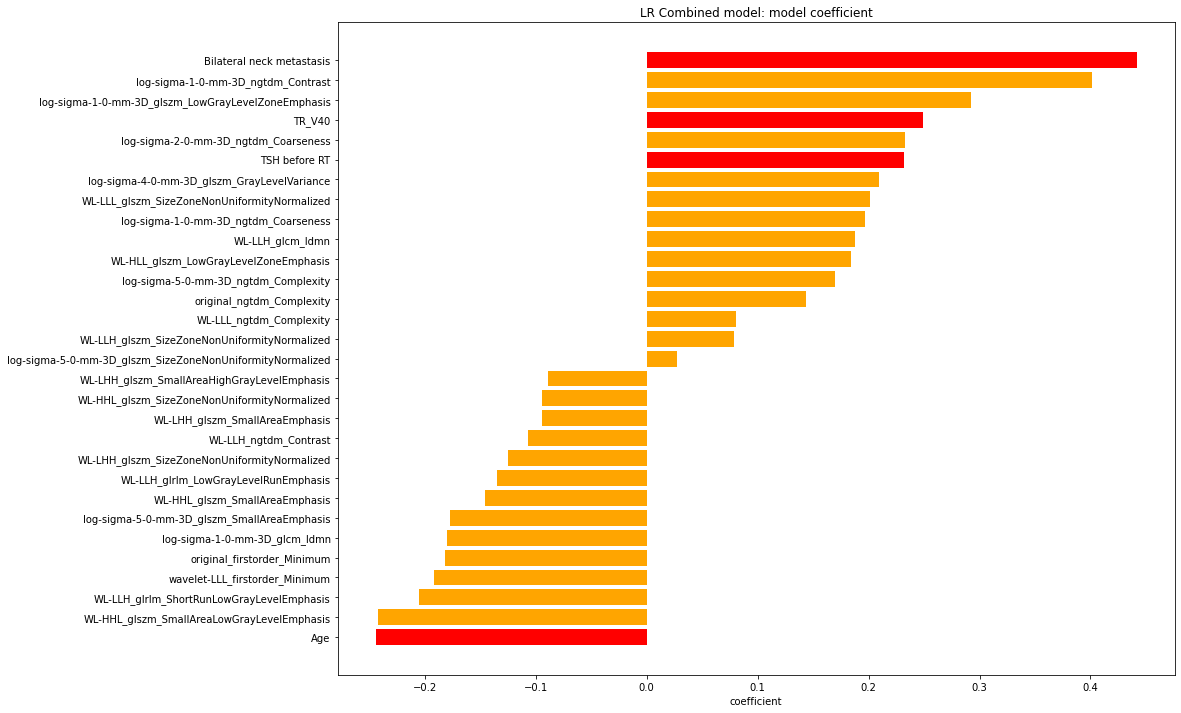

In [25]:
coeff = model.coef_[0]
indices = np.argsort(coeff)

plt.figure(figsize = (15, 12))
plt.title('LR Combined model: model coefficient')
plt.barh(range(len(indices)), coeff[indices], color=['r', 'orange', 'orange', 'orange', 'orange', 'orange','orange', 
                                                     'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 
                                                     'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 
                                                     'orange', 'orange', 'orange', 'orange', 'orange', 'r','orange',
                                                     'r', 'orange', 'orange', 'r' ], align='center')
plt.yticks(range(len(indices)), labels = data)
plt.xlabel('coefficient')
plt.show()